## Step 1 Load Data and Train-test Split

In [76]:
import numpy as np
from numpy import *
import random


def load_rating_data(file_path="../data/ml-latest-small/ratings.csv"):
    """
    load movie lens 100k ratings from original rating file.
    need to download and put rating data in /data folder first.
    Source: http://www.grouplens.org/
    """
    prefer = []
    for line in open(file_path, 'r'):  # 打开指定文件
        (userid, movieid, rating, ts) = line.split(',')  # 数据集中每行有4项
        if(userid=="userId"): continue
        uid = int(userid)
        mid = int(movieid)
        rat = float(rating)
        prefer.append([uid, mid, rat])
    data = array(prefer)
    return data

In [77]:
data=load_rating_data()
data

array([[1.00000e+00, 1.00000e+00, 4.00000e+00],
       [1.00000e+00, 3.00000e+00, 4.00000e+00],
       [1.00000e+00, 6.00000e+00, 4.00000e+00],
       ...,
       [6.10000e+02, 1.68250e+05, 5.00000e+00],
       [6.10000e+02, 1.68252e+05, 5.00000e+00],
       [6.10000e+02, 1.70875e+05, 3.00000e+00]])

In [78]:
new_data = data[data[:,1].argsort()]

In [79]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(new_data[:, 1])
a=le.transform(new_data[:, 1])
c=np.array(a).reshape(100836,1)

In [80]:
final_data = np.concatenate((new_data,c),axis=1)
final_data=final_data[:,[0,3,2]]

In [ ]:
train, test = train_test_split(final_data)

## Step2 Matrix Factorization (probabilistic-matrix-factorization)

In [81]:
import numpy as np

class PMF(object):
    def __init__(self, num_feat=10, epsilon=1, _lambda1=0.1,_lambda2=0.1, momentum=0.8, maxepoch=20, num_batches=10, batch_size=1000):
        self.num_feat = num_feat  
        self.epsilon = epsilon  
        self._lambda1 = _lambda1  
        self._lambda2 = _lambda2  
        self.momentum = momentum  
        self.maxepoch = maxepoch  
        self.num_batches = num_batches  
        self.batch_size = batch_size  

        self.w_Movie = None  # matrix for movie
        self.w_User = None  # matrix for user

        self.rmse_train = []
        self.rmse_test = []

    # ***Fit the model with train_tuple and evaluate RMSE on both train and test data.  ***********#
    # ***************** train_vec=TrainData, test_vec=TestData*************#
    
    def fit(self, train_vec, test_vec):
        
        self.mean_inv = np.mean(train_vec[:, 2])  # rating mean

        pairs_train = train_vec.shape[0]  # the number of lines in traindata 
        pairs_test = test_vec.shape[0]  # the number of lines in testdata

        num_user = int(max(np.amax(train_vec[:, 0]), np.amax(test_vec[:, 0]))) + 1  # the total number of user
        num_item = int(max(np.amax(train_vec[:, 1]), np.amax(test_vec[:, 1]))) + 1  # the total number of movie

        incremental = False  
        if ((not incremental) or (self.w_Item is None)):
            # initialize
            self.epoch = 0
            self.w_Movie = 0.1 * np.random.randn(num_item, self.num_feat)  # numpy.random.randn movie: M x D normal-distributed-matrix
            self.w_User = 0.1 * np.random.randn(num_user, self.num_feat)  # numpy.random.randn user: N x D normal-distributed-matrix

            self.w_Movie_inc = np.zeros((num_item, self.num_feat))  # movie: M x D 0-matrix
            self.w_User_inc = np.zeros((num_user, self.num_feat))  # user: N x D 0-matrix

        while self.epoch < self.maxepoch:  # check the number of iterations
            self.epoch += 1

            # Shuffle training truples
            shuffled_order = np.arange(train_vec.shape[0])  
            np.random.shuffle(shuffled_order)  

            # Batch update
            for batch in range(self.num_batches):  
                test = np.arange(self.batch_size * batch, self.batch_size * (batch + 1))
                batch_idx = np.mod(test, shuffled_order.shape[0])  

                batch_UserID = np.array(train_vec[shuffled_order[batch_idx], 0], dtype='int32')
                batch_MovieID = np.array(train_vec[shuffled_order[batch_idx], 1], dtype='int32')

                # Compute Objective Function
                pred_out = np.sum(np.multiply(self.w_User[batch_UserID, :],
                                              self.w_Movie[batch_MovieID, :]),
                                  axis=1)  

                rawErr = pred_out - train_vec[shuffled_order[batch_idx], 2]

                # Compute gradients
                Ix_User = 2 * np.multiply(rawErr[:, np.newaxis], self.w_Movie[batch_MovieID, :]) \
                       + self._lambda1 * self.w_User[batch_UserID, :]
                Ix_Movie = 2 * np.multiply(rawErr[:, np.newaxis], self.w_User[batch_UserID, :]) \
                       + self._lambda2 * (self.w_Movie[batch_MovieID, :])  # np.newaxis :increase the dimension

                dw_Movie = np.zeros((num_item, self.num_feat))
                dw_User = np.zeros((num_user, self.num_feat))

                # loop to aggreate the gradients of the same element
                for i in range(self.batch_size):
                    dw_Movie[batch_MovieID[i], :] += Ix_Movie[i, :]
                    dw_User[batch_UserID[i], :] += Ix_User[i, :]

                # Update with momentum
                self.w_Movie_inc = self.momentum * self.w_Movie_inc + self.epsilon * dw_Movie / self.batch_size
                self.w_User_inc = self.momentum * self.w_User_inc + self.epsilon * dw_User / self.batch_size

                self.w_Movie = self.w_Movie - self.w_Movie_inc
                self.w_User = self.w_User - self.w_User_inc

                # Compute Objective Function after
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(train_vec[:, 0], dtype='int32'), :],
                                                  self.w_Movie[np.array(train_vec[:, 1], dtype='int32'), :]),
                                      axis=1)  
                    rawErr = pred_out - train_vec[:, 2]
                    obj = 0.5*np.linalg.norm(rawErr) ** 2 \
                          + 0.5 * self._lambda1 * np.linalg.norm(self.w_User) ** 2 + 0.5 * self._lambda2 * np.linalg.norm(self.w_Movie) ** 2

                    self.rmse_train.append(np.sqrt(obj / pairs_train))

                # Compute validation error
                if batch == self.num_batches - 1:
                    pred_out = np.sum(np.multiply(self.w_User[np.array(test_vec[:, 0], dtype='int32'), :],
                                                  self.w_Movie[np.array(test_vec[:, 1], dtype='int32'), :]),
                                      axis=1)
                    rawErr = pred_out - test_vec[:, 2]
                    self.rmse_test.append(np.linalg.norm(rawErr) / np.sqrt(pairs_test))

                    # Print info
                    #if batch == self.num_batches - 1:
                        #print('Training RMSE: %f, Test RMSE %f' % (self.rmse_train[-1], self.rmse_test[-1]))

    def predict(self):
        return np.dot(self.w_Movie, self.w_User)

    # ****************Set parameters by providing a parameter dictionary.  ***********#
    def set_params(self, parameters):
        if isinstance(parameters, dict):
            self.num_feat = parameters.get("num_feat", 10)
            self.epsilon = parameters.get("epsilon", 1)
            self._lambda1 = parameters.get("_lambda1", 0.1)
            self._lambda2 = parameters.get("_lambda2", 0.1)
            self.momentum = parameters.get("momentum", 0.8)
            self.maxepoch = parameters.get("maxepoch", 20)
            self.num_batches = parameters.get("num_batches", 10)
            self.batch_size = parameters.get("batch_size", 1000)

## Step 2.2 Tuning Parameter

In [90]:
num_feat_list=np.arange(10,40,10)
lambda1_list=np.array([0.05,0.1,0.2])
lambda2_list=np.array([0.05,0.1,0.2])

num_latent = 10 lambda for user = 0.05 lambda for movie = 0.05
For Training DataSet 0.532331936335816
For Testing DataSet 1.2042094460936121


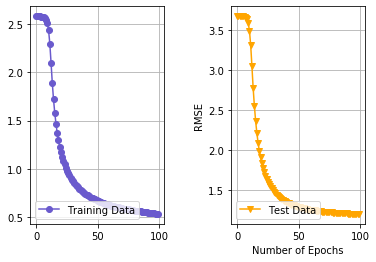

num_latent = 10 lambda for user = 0.05 lambda for movie = 0.1
For Training DataSet 0.5371931923328609
For Testing DataSet 1.2009723442344602


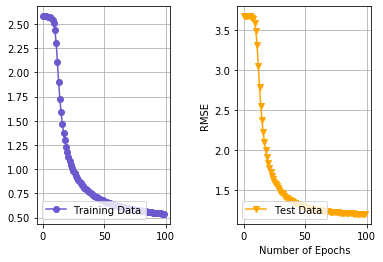

num_latent = 10 lambda for user = 0.05 lambda for movie = 0.2
For Training DataSet 0.5473048785633512
For Testing DataSet 1.196327008026982


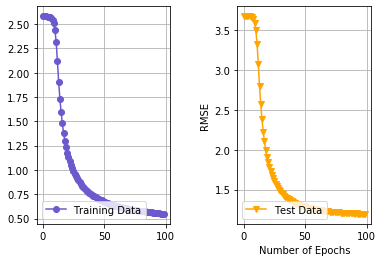

num_latent = 10 lambda for user = 0.1 lambda for movie = 0.05
For Training DataSet 0.532331936335816
For Testing DataSet 1.2042094460936121


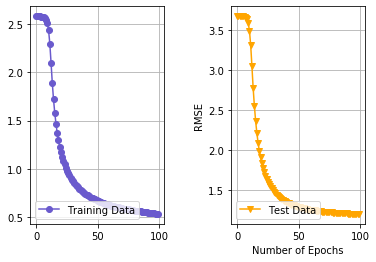

num_latent = 10 lambda for user = 0.1 lambda for movie = 0.1
For Training DataSet 0.5371931923328609
For Testing DataSet 1.2009723442344602


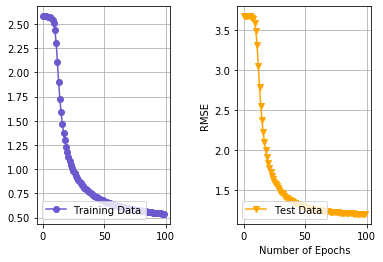

num_latent = 10 lambda for user = 0.1 lambda for movie = 0.2
For Training DataSet 0.5473048785633512
For Testing DataSet 1.196327008026982


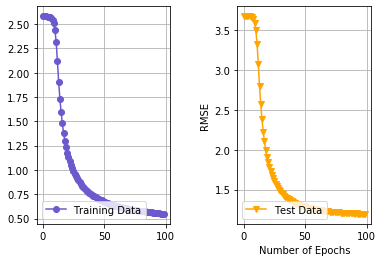

num_latent = 10 lambda for user = 0.2 lambda for movie = 0.05
For Training DataSet 0.532331936335816
For Testing DataSet 1.2042094460936121


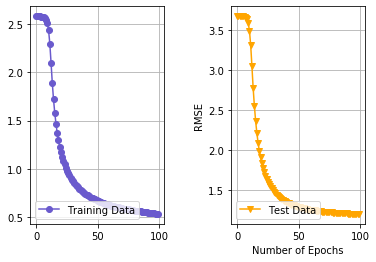

num_latent = 10 lambda for user = 0.2 lambda for movie = 0.1
For Training DataSet 0.5371931923328609
For Testing DataSet 1.2009723442344602


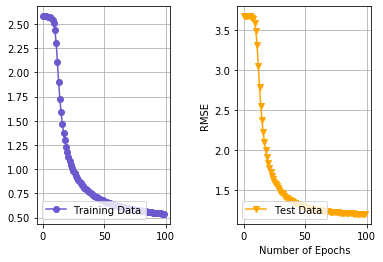

num_latent = 10 lambda for user = 0.2 lambda for movie = 0.2
For Training DataSet 0.5473048785633512
For Testing DataSet 1.196327008026982


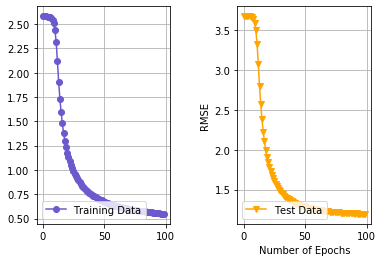

num_latent = 20 lambda for user = 0.05 lambda for movie = 0.05
For Training DataSet 0.49288518485558963
For Testing DataSet 1.215813199646121


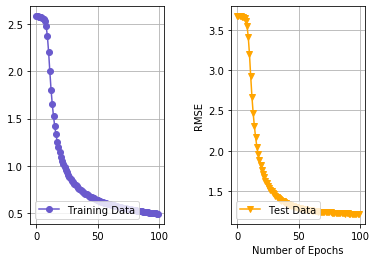

num_latent = 20 lambda for user = 0.05 lambda for movie = 0.1
For Training DataSet 0.5006769917006753
For Testing DataSet 1.211327909731876


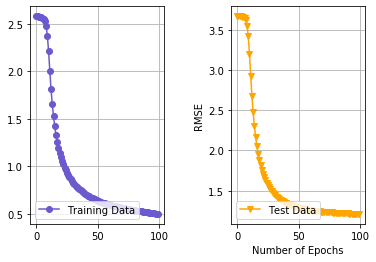

num_latent = 20 lambda for user = 0.05 lambda for movie = 0.2
For Training DataSet 0.5158513070671988
For Testing DataSet 1.2050315398565465


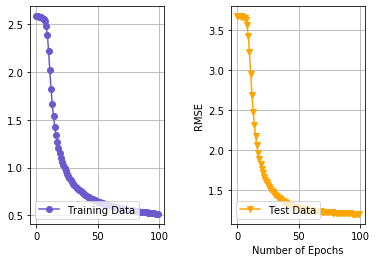

num_latent = 20 lambda for user = 0.1 lambda for movie = 0.05
For Training DataSet 0.49288518485558963
For Testing DataSet 1.215813199646121


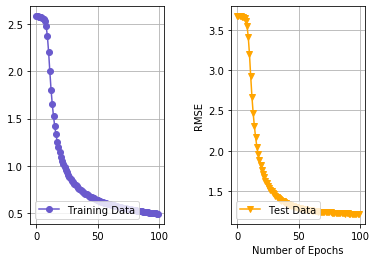

num_latent = 20 lambda for user = 0.1 lambda for movie = 0.1
For Training DataSet 0.5006769917006753
For Testing DataSet 1.211327909731876


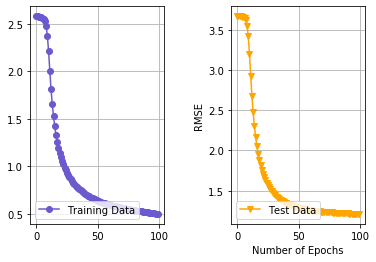

num_latent = 20 lambda for user = 0.1 lambda for movie = 0.2
For Training DataSet 0.5158513070671988
For Testing DataSet 1.2050315398565465


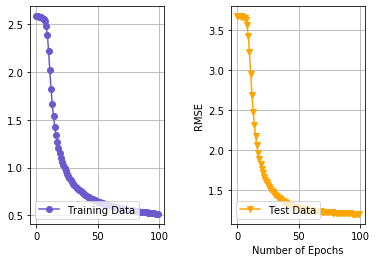

num_latent = 20 lambda for user = 0.2 lambda for movie = 0.05
For Training DataSet 0.49288518485558963
For Testing DataSet 1.215813199646121


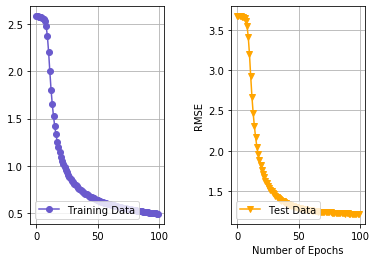

num_latent = 20 lambda for user = 0.2 lambda for movie = 0.1
For Training DataSet 0.5006769917006753
For Testing DataSet 1.211327909731876


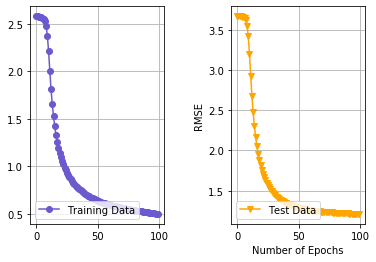

num_latent = 20 lambda for user = 0.2 lambda for movie = 0.2
For Training DataSet 0.5158513070671988
For Testing DataSet 1.2050315398565465


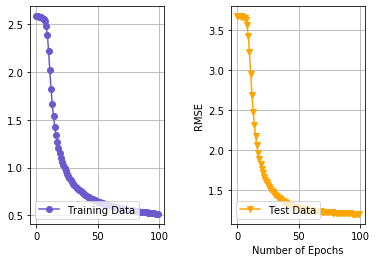

num_latent = 30 lambda for user = 0.05 lambda for movie = 0.05
For Training DataSet 0.4686345857091083
For Testing DataSet 1.2153994623178268


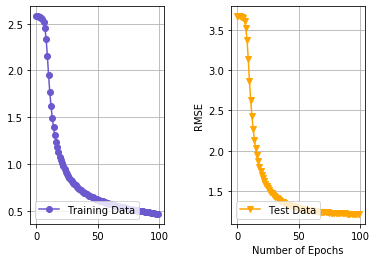

num_latent = 30 lambda for user = 0.05 lambda for movie = 0.1
For Training DataSet 0.47874229790067724
For Testing DataSet 1.21087570298793


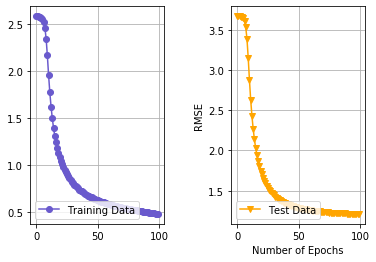

num_latent = 30 lambda for user = 0.05 lambda for movie = 0.2
For Training DataSet 0.498013287233695
For Testing DataSet 1.204561788261344


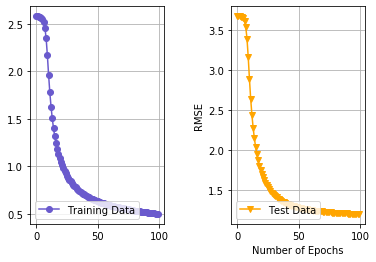

num_latent = 30 lambda for user = 0.1 lambda for movie = 0.05
For Training DataSet 0.4686345857091083
For Testing DataSet 1.2153994623178268


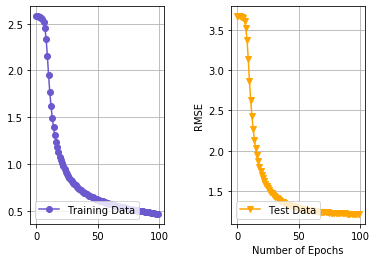

num_latent = 30 lambda for user = 0.1 lambda for movie = 0.1
For Training DataSet 0.47874229790067724
For Testing DataSet 1.21087570298793


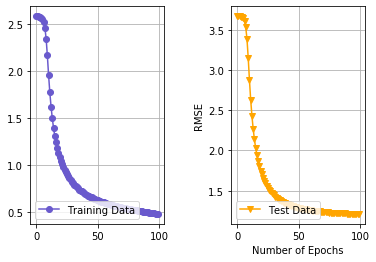

num_latent = 30 lambda for user = 0.1 lambda for movie = 0.2
For Training DataSet 0.498013287233695
For Testing DataSet 1.204561788261344


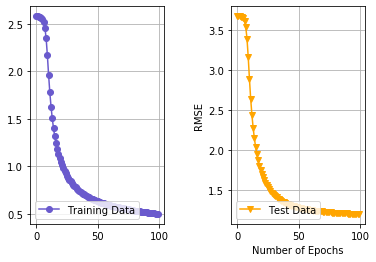

num_latent = 30 lambda for user = 0.2 lambda for movie = 0.05
For Training DataSet 0.4686345857091083
For Testing DataSet 1.2153994623178268


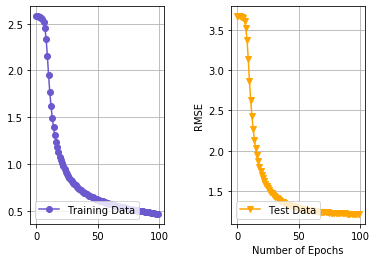

num_latent = 30 lambda for user = 0.2 lambda for movie = 0.1
For Training DataSet 0.47874229790067724
For Testing DataSet 1.21087570298793


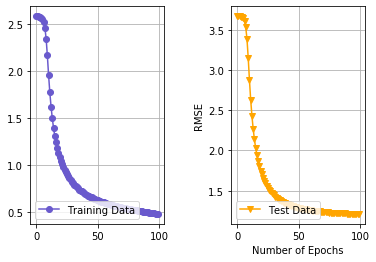

num_latent = 30 lambda for user = 0.2 lambda for movie = 0.2
For Training DataSet 0.498013287233695
For Testing DataSet 1.204561788261344


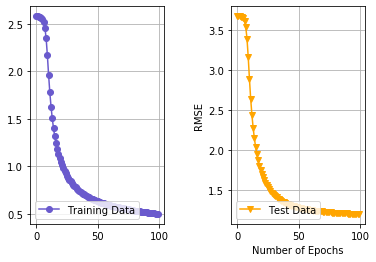

In [116]:
K=5
n=len(train)
for i in num_feat_list:
    for j in lambda1_list:
        for z in lambda2_list:
            pmf.set_params({"num_feat": i, "epsilon": 1, "_lambda": j, "_lambda2": z,"momentum": 0.8, "maxepoch": 100, "num_batches": 10,
                    "batch_size": 1000})
            print('num_latent =',i,'lambda for user =',j,'lambda for movie =',z)
            nfold = round(len(train)/K)
            catego = np.repeat(list(range(1,K+1)), [nfold]*(K-1)+ [n-(K-1)*nfold])
            np.random.seed(1)
            s = np.random.choice(catego, size=len(catego), replace=False)
            for k in range(1,K+1):
                X_train = train[s!=k,:]
                X_test = train[s==k,:]
                train_error=[]
                test_error=[]
                pmf.fit(X_train, X_test)
            train_error.append(pmf.rmse_train[-100:])
            test_error.append(pmf.rmse_test[-100:])
            RMSE_train=np.mean(train_error,axis=0)
            RMSE_test=np.mean(test_error,axis=0)
            print('For Training DataSet',RMSE_train[-1])
            print('For Testing DataSet',RMSE_test[-1])
            fig, axs = plt.subplots(1,2)
            plt.subplots_adjust(wspace =0.5, hspace =0)
            axs[0].plot(range(pmf.maxepoch), RMSE_train, marker='o', label='Training Data',color='#6A5ACD')
            axs[1].plot(range(pmf.maxepoch), RMSE_test, marker='v', label='Test Data',color='#FFA500')
            plt.xlabel('Number of Epochs')
            plt.ylabel('RMSE')
            axs[0].legend(loc = 3)
            axs[1].legend(loc = 3)
            axs[0].grid()
            axs[1].grid()
            plt.show()

Run Example

After tuning parameter we choose the number of latent variables as 10 and _lambda for user = 0.1 and _lambda for movie = 0.2

The number of Latent Factors: 10 The lambda for User: 0.1 The lambda for Movie: 0.2
RMSE for Train 0.581317136295053
RMSE for Test 1.1543185047924882


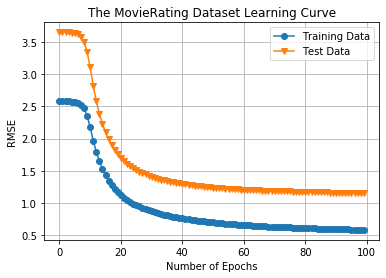

In [117]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

if __name__ == "__main__":
    #file_path = "data/ml-100k/ratings.csv"
    pmf = PMF()
    pmf.set_params({"num_feat": 10, "epsilon": 1, "_lambda1": 0.1,"_lambda2": 0.2, "momentum": 0.8, "maxepoch": 100, "num_batches": 10,
                    "batch_size": 1000})
    print('The number of Latent Factors:',pmf.num_feat, 'The lambda for User:',pmf._lambda1,'The lambda for Movie:',pmf._lambda2)
    train, test = train_test_split(final_data)
    pmf.fit(train, test)
    print('RMSE for Train',pmf.rmse_train[-1])
    print('RMSE for Test',pmf.rmse_test[-1])
    # Check performance by plotting train and test errors
    plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
    plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
    plt.title('The MovieRating Dataset Learning Curve')
    plt.xlabel('Number of Epochs')
    plt.ylabel('RMSE')
    plt.legend()
    plt.grid()
    plt.show()


# pred_rating matrix

In [118]:
a=np.dot(pmf.w_User,pmf.w_Movie.T)
pred_matrix_final=a[:-1,]
np.shape(pred_matrix_final)

(610, 9724)

In [119]:
# train and test data transformation to 610*9724

In [120]:
R_test=np.zeros((610,9724))
R_train=np.zeros((610,9724))

# train data transformation
for i in range(0,train.shape[0]):
    user=train[i,0].astype(int)
    movie=train[i,1].astype(int)
    rating=train[i,2]
    R_train[user-1,movie-1]=rating
    
# test data transformation
for i in range(0,test.shape[0]):
    user=test[i,0].astype(int)
    movie=test[i,1].astype(int)
    rating=test[i,2]
    R_test[user-1,movie-1]=rating

# Step 3 Post-processing (SVD with KNN)

In [121]:
# Compute the Cosine Similarity matrix based on the count_matrix
from sklearn.metrics.pairwise import cosine_similarity

###########################################################################
###If we want to recommend by movie, do result['M'], else just use result['U']###
###########################################################################
result=pmf.w_Movie
Moviematrix = result
cosine_sim2 = cosine_similarity(Moviematrix, Moviematrix)

In [122]:
def get_recommendations(idx, cosine_sim=cosine_sim2):

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    #sim_scores = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the indices of the sorted similar movies
    return movie_indices

In [123]:
R_predict = np.zeros(shape=(610,9724)) # the predict matrix

In [124]:
for i in range(610):
    for j in range(9724):
        if R_test[i,j] != 0:
            reclist = get_recommendations(j)
            for z in reclist:
                if R_train[i,z]!=0:
                    R_predict[i,j] = R_train[i,z]
                    continue

## Step 4 Evaluation

In [125]:
import math
math.sqrt(sum((R_test-R_predict)**2)/test.shape[0])

1.3221482836422986